# Recovery of Lost Organs in 16x16 Smiley-Face NCA

The 16x16 Smiley-Face NCA's fitness decreases over time primarily through the loss of its internal organs, i.e., its eyes, and the mouth.

Thus, we here aim at (i) detecting these losses individually, and (ii) injecting corresponding cells into the NCA (by changing cell types of effected cells) that help restoring the original organ.

i) The organs fitness detection is done by respectively masking the organs _and their sockets_ in the tissue, and evaluating the relative number of correct cells.

ii) The injection is done either with the initial cell state or with the desired target state.

## Presets and imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from mindcraft import World, Agent
from aging import rollout_lifetime, load_data, save_data
import recovery

## Reference Behavior for Long Lifetime

### Pretrained agents and folders

In [4]:
morphogen = "smiley_16x16"
world_path = f"agents/{morphogen}/world.yml"
aging_path = f"data/aging/recovery/socket_loss/{morphogen}"

In [5]:
os.makedirs(aging_path, exist_ok=True)

### Evaluate or load dynamics

In [6]:
try:
    data_trained = load_data(filename=os.path.join(aging_path, "default-behavior.h5"))
    
except:
    data_trained = rollout_lifetime(world_config=world_path, 
                                    competency_schedule=recovery.competency_level,
                                    noise_schedule=recovery.noise_level,
                                    ann_schedule=None,
                                    max_steps=recovery.max_steps, num_episodes=recovery.num_episodes,
                                    verbose=False, render=False,
                                    **recovery.logging
                                   )

    save_data(data_trained, filename=os.path.join(aging_path, "default-behavior.h5"))
    data_trained = load_data(filename=os.path.join(aging_path, "default-behavior.h5"))

loading from 'data/aging/recovery/socket_loss/smiley_16x16/default-behavior.h5'
node: 'action', shape: (10, 1001, 16, 16, 4)
node: 'competency_schedule', shape: ()
node: 'cumulative_reward', shape: (10, 1001)
node: 'embedding', shape: (10, 1001, 16, 16, 8)
node: 'intervened', shape: (10, 1001)
node: 'noise_schedule', shape: ()
node: 'reward', shape: (10, 1001)
node: 'state', shape: (10, 1001, 16, 16, 4)
node: 'type', shape: (10, 1001, 16, 16)


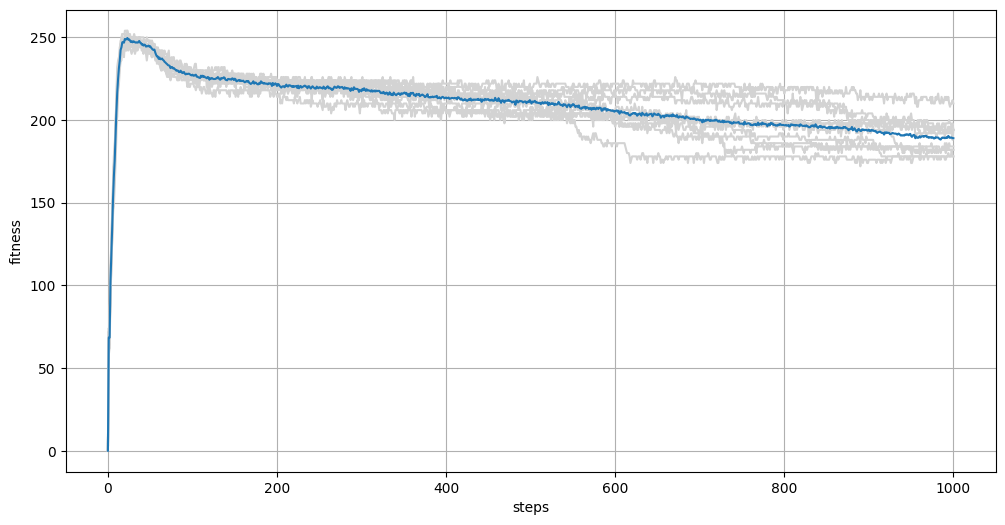

In [7]:
plt.figure(figsize=(12,6))
plt.plot(data_trained["cumulative_reward"].T, color="lightgray")
plt.plot(data_trained["cumulative_reward"].mean(axis=0))
plt.ylabel("fitness")
plt.xlabel("steps")
plt.grid()

In [8]:
data_trained.keys()

dict_keys(['action', 'competency_schedule', 'cumulative_reward', 'embedding', 'intervened', 'noise_schedule', 'reward', 'state', 'type'])

In [9]:
## uncomment for movie of `data_trained` trajectories
# recovery.get_movie(data_trained, export_path=os.path.join(aging_path, "default-behavior.mp4"))

### Display developmental (aging) trajectory for different phenotype-realizations, and define organ-mask

export to data/aging/recovery/socket_loss/smiley_16x16/default-behaviour-selected-steps-and-mask.png


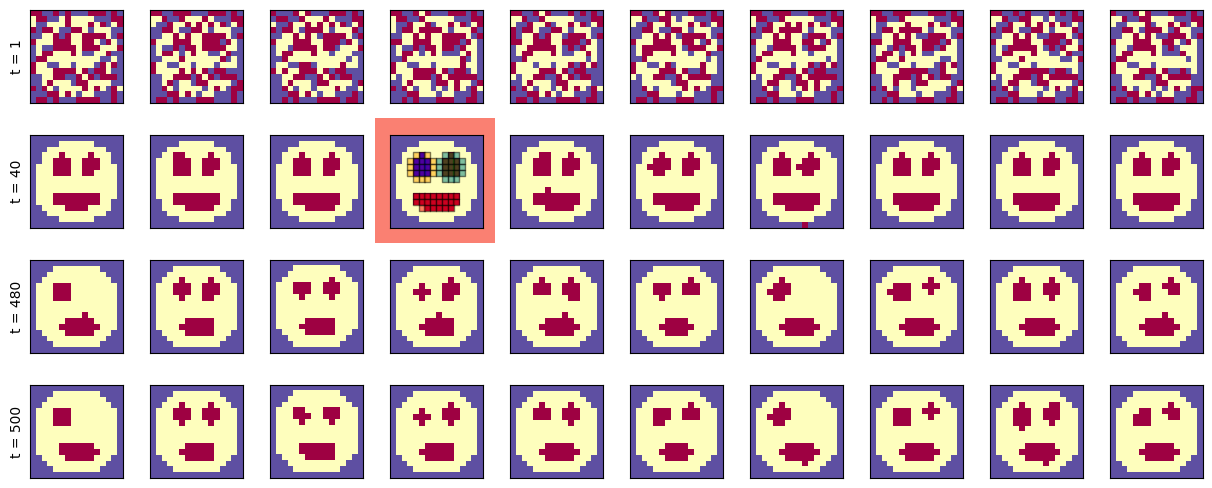

In [10]:
times = [1, 40, 480, 500]
states = [data_trained["state"][:, t] for t in times]

fig = plt.figure(figsize=(12,5))
subfigs = fig.subfigures(ncols=recovery.num_episodes, nrows=len(times))

ims = []
axes = []
for i in range(len(times)):
    ax_row = []
    axes.append(ax_row)
    for j in range(recovery.num_episodes): 
        ax = subfigs[i][j].subplots()
        data = states[i][j][..., :3].argmax(axis=-1)
        ims.append(ax.imshow(data, cmap='Spectral_r', vmin=0, vmax=2, interpolation="none"))
        ax.set_xticks([])
        ax.set_yticks([])

        ax_row.append(ax)

    ax_row[0].set_ylabel(f"t = {times[i]}")

left_eye = np.array([        [5, 3], 
                     [4, 4], [5, 4], [6, 4],
                     [4, 5], [5, 5], [6, 5],
                     [4, 6], [5, 6], [6, 6],
                    ])

left_eye_socket = np.array([        [4, 3],         [6, 3],
                            [3, 4],                         [7, 4],
                            [3, 5],                         [7, 5],
                            [3, 6],                         [7, 6],
                                    [4, 7], [5, 7], [6, 7]
                           ])

right_eye = [15, 0] + left_eye * [[-1, 1]]
right_eye_socket = [15, 0] + left_eye_socket * [[-1, 1]]

mouth = np.concatenate([[[4 + i, 10] for i in range(8)],
                        [[4 + i, 11] for i in range(8)],
                        [[5 + i, 12] for i in range(6)],
                       ])

subfigs[1][3].set_facecolor("salmon")
axes[1][3].scatter(*left_eye.T, color="blue", marker="s", alpha=0.5, edgecolor="black", s=16)
axes[1][3].scatter(*left_eye_socket.T, color="orange", marker="s", alpha=0.5, edgecolor="black", s=16)
axes[1][3].scatter(*right_eye.T, color="green", marker="s", alpha=0.5, edgecolor="black", s=16)
axes[1][3].scatter(*right_eye_socket.T, color="teal", marker="s", alpha=0.5, edgecolor="black", s=16)
axes[1][3].scatter(*mouth.T, color="red", marker="s", alpha=0.5, edgecolor="black", s=16)

fig_path = os.path.join(aging_path, "default-behaviour-selected-steps-and-mask.png")
print(f"export to {fig_path}")
fig.savefig(fig_path, dpi=300)

export to data/aging/recovery/socket_loss/smiley_16x16/default-behaviour-selected-mask-target.png


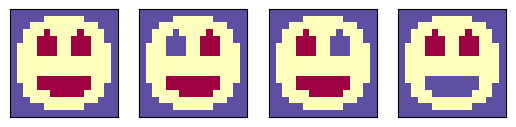

In [11]:
s0 = states[1][3].copy()

f, axes = plt.subplots(1, 4)
axes[0].imshow(s0[..., :3].argmax(axis=-1), cmap="Spectral_r")

s0_left_eye = s0.copy()
s0_left_eye[left_eye[:, 1], left_eye[:, 0]] = 3
axes[1].imshow(s0_left_eye[..., :3].argmax(axis=-1), cmap="Spectral_r")

s0_right_eye = s0.copy()
s0_right_eye[right_eye[:, 1], right_eye[:, 0]] = 3
axes[2].imshow(s0_right_eye[..., :3].argmax(axis=-1), cmap="Spectral_r")

s0_mouth = s0.copy()
s0_mouth[mouth[:, 1], mouth[:, 0]] = 3
axes[3].imshow(s0_mouth[..., :3].argmax(axis=-1), cmap="Spectral_r")

[ax.set_xticks([]) for ax in axes]
[ax.set_yticks([]) for ax in axes]

fig_path = os.path.join(aging_path, "default-behaviour-selected-mask-target.png")
print(f"export to {fig_path}")
f.savefig(fig_path, dpi=300)

### Organ-specific fitness

export to data/aging/recovery/socket_loss/smiley_16x16/default-behavior-organ-fitness.png
export to data/aging/recovery/socket_loss/smiley_16x16/default-behavior-organ-fitness-counts.png


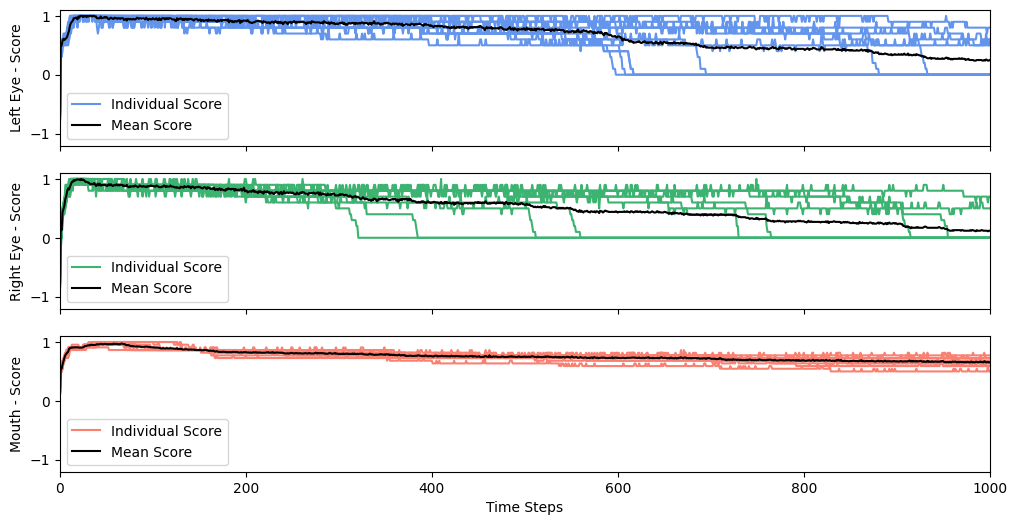

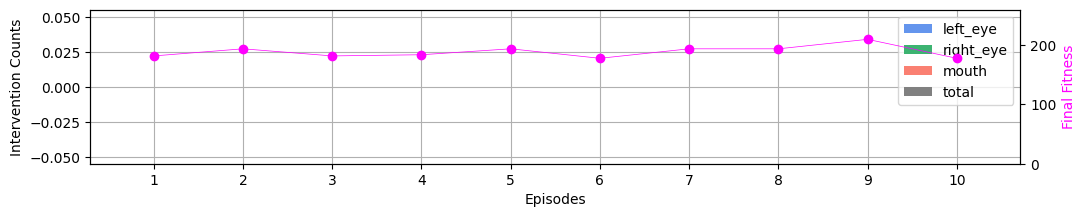

In [12]:
organs = dict(left_eye=left_eye, right_eye=right_eye, mouth=mouth,
              left_eye_socket=left_eye_socket, right_eye_socket=right_eye_socket,
             )
f1, f2 = recovery.plot_organ_fitness(data_trained, **organs)

fig_path = os.path.join(aging_path, "default-behavior-organ-fitness.png")
print(f"export to {fig_path}")
f1.savefig(fig_path, dpi=300)

fig_path = os.path.join(aging_path, "default-behavior-organ-fitness-counts.png")
print(f"export to {fig_path}")
f2.savefig(fig_path, dpi=300)

In [13]:
from matplotlib.ticker import MaxNLocator

def plot_partial_fitness(df, traj, ax, ax_hist):
    fitness = recovery.get_organ_fitness(df["state"][traj][..., :3].argmax(axis=-1), **organs)
    fitness = pd.DataFrame(fitness)

    if ax is not None:            
        ax.plot(np.linspace(0, 1000, 1001)[1:], fitness["left_eye"].values[1:], color="cornflowerblue", zorder=0, label="Left Eye")
        ax.plot(np.linspace(0, 1000, 1001)[1:], fitness["right_eye"].values[1:], color="mediumseagreen", zorder=0, label="Right Eye")
        ax.plot(np.linspace(0, 1000, 1001)[1:], fitness["mouth"].values[1:], color="salmon", zorder=0, label="Mouth")

    intervention_times = recovery.get_intervention_times(df)
    intervention_count = {"left_eye": 0, "right_eye": 0, "mouth": 0}
    colors = ("cornflowerblue", "mediumseagreen", "salmon", )# "gray")
    for k, c in zip(intervention_count.keys(), colors):
        t = []
        for intervention_time in intervention_times[traj].get(k, []):
            t += [intervention_time-1]
            intervention_count[k] += 1

        label = None
        if ax is not None:
            ax.scatter(t, fitness[k].values[t], c=c, edgecolor="black", marker='*', s=100, linewidth=1., label=label)

    intervention_count["total"] = sum(intervention_count.values())

    multiplier = 0
    width = 0.1
    offset = -0.125 - 0.0625
    keys = "left_eye", "right_eye", "mouth" #, "total"
    values = [intervention_count[k] for k in keys]
    if ax is not None:
        ax_hist.bar(keys, values, color=colors, edgecolor="black")

    return intervention_count

def plot_recovery(df, main_offset=2, num_trajectories=5, col_span=2, num_time=1000, trajs=None, **kwargs):
    fig = plt.figure(figsize=(6.5, 7))
    gs = fig.add_gridspec(main_offset + (num_trajectories if trajs is None else len(trajs)), 12)

    main_ax = fig.add_subplot(gs[:main_offset, :-col_span])
    recovery.plot_reward(df, data_default=data_trained, fig=fig, ax=main_ax)
    main_ax.set_xticklabels([])
    
    main_highlight_ax = fig.add_subplot(gs[:main_offset, -col_span:])
    main_highlight_ax.yaxis.tick_right()  # Move ticks to the right side
    main_highlight_ax.yaxis.set_label_position("right")  # Move y-axis label to the right side
    main_highlight_ax.set_xticklabels([])
    
    trajs = np.arange(num_trajectories) if trajs is None else trajs
    traj_ax = None
    share_xy = None
    intervention_count = {"left_eye": [], "right_eye": [], "mouth": [], "total": []}
    visited = []
    for i in range(num_trajectories):
        row = i + main_offset

        traj_ax, highlight_ax = None, None
        if i < len(trajs):
            traj_ax = fig.add_subplot(gs[row, :-col_span], sharey=traj_ax)
    
            highlight_ax = fig.add_subplot(gs[row, -col_span:], sharey=share_xy)
            highlight_ax.yaxis.tick_right()  # Move ticks to the right side
            highlight_ax.yaxis.set_label_position("right")  # Move y-axis label to the right side
            highlight_ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=3))
            highlight_ax.grid()
            share_xy = highlight_ax

        try:
            traj = trajs[i]
            traj_ax.set_ylabel("O.-Score")
            traj_ax.grid()
            highlight_ax.set_ylabel("Evnt. Cnt.")
            traj_ax.set_xlim([0, 1000])

        except IndexError:
            j = None
            for j in range(num_trajectories):
                if j not in trajs and j not in visited:
                    visited.append(j)
                    break
            traj = j

        c = plot_partial_fitness(df, traj, traj_ax, highlight_ax)
        for k, v in c.items():
            intervention_count[k].append(v)

        if i < len(trajs) - 1:
            highlight_ax.set_xticklabels([])
            traj_ax.set_xticklabels([])

        if i == len(trajs) - 1:
            highlight_ax.set_xticklabels(["Left Eye", "Right Eye", "Mouth"], rotation=45)
            traj_ax.set_xlabel("Time Steps, $t_k$")
            
        if i == 0:
            traj_ax.legend()

    keys = "left_eye", "right_eye", "mouth" #, "total"
    values = [np.mean(intervention_count[k]) for k in keys]
    colors = ("cornflowerblue", "mediumseagreen", "salmon", )# "gray")
    main_highlight_ax.bar(keys, values, color=colors, edgecolor="black")
    main_highlight_ax.grid()
    main_highlight_ax.set_ylabel("Avg. Event Count")

    filename = recovery.get_filename("socket", postfix="pdf", **kwargs)
    filename = os.path.join(aging_path, filename.replace(".pdf", "-paper-fig.pdf"))
    print(f"export figure {filename}")
    fig.savefig(filename, dpi=300)

## Interventions of degenerative process with target cell-recovery

### Retrieve `embryonic` information from structural genome (the agent's `state_module`)

In [14]:
agent_path = world_path.replace("world.yml", "agent.yml")
agent = Agent.make(agent_path)
initial_state = agent.state_module.state.reshape(recovery.Nx, recovery.Ny, recovery.N_state).detach()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


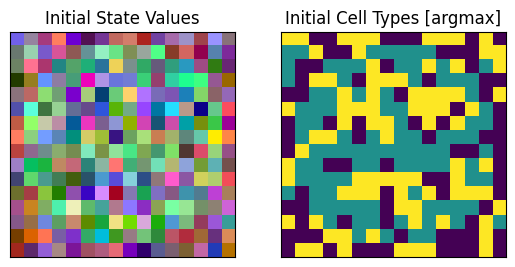

export to data/aging/recovery/socket_loss/smiley_16x16/default-behaviour-initial-state.png


In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.imshow((initial_state[..., :3] + 3) / 6)
ax1.set_title("Initial State Values")
ax1.set_xticks([]); ax1.set_yticks([])

ax2.imshow(initial_state[..., :3].argmax(dim=-1))
ax2.set_title("Initial Cell Types [argmax]")
ax2.set_xticks([]); ax2.set_yticks([])
plt.show()

fig_path = os.path.join(aging_path, "default-behaviour-initial-state.png")
print(f"export to {fig_path}")
f.savefig(fig_path, dpi=300)

### Inject entire "__embryonic__" organ after sufficient damage

In [16]:
recovery_data_01_kwargs = dict(
    threshold    = 0.6,    # threshold for intervention (if organ relative fitness is below this value)
    development  = 150,     # developmental stage, no intervention until this time
    horizon      = 25,     # time steps between interventions
    reset_memory = True,    # boolean to control whether to erase RNN state of intervened cells
    inject_initial = initial_state,  # whether to inject the initial or the mature state)
    only_correct_wrongs = False,
    **organs
)


filename = os.path.join(aging_path, recovery.get_filename(recover="socket", **recovery_data_01_kwargs))
try:
    recovery_data_01 = load_data(filename=filename)
    
except:
    recovery_data_01 = recovery.run_recovery(world_path=world_path, **recovery_data_01_kwargs)
    save_data(recovery_data_01, filename=filename)


loading from 'data/aging/recovery/socket_loss/smiley_16x16/recover_socket-threshold_0.6-development_150-horizon_25-rnnstate_reset-inject_init-correct_all.h5'
node: 'action', shape: (10, 1001, 16, 16, 4)
node: 'cumulative_reward', shape: (10, 1001)
node: 'embedding', shape: (10, 1001, 16, 16, 8)
node: 'left_eye_interventions', shape: (10, 1001)
node: 'mouth_interventions', shape: (10, 1001)
node: 'reward', shape: (10, 1001)
node: 'right_eye_interventions', shape: (10, 1001)
node: 'state', shape: (10, 1001, 16, 16, 4)
node: 'type', shape: (10, 1001, 16, 16)


#### Partial fitness plot and intervention count statistics

export figure data/aging/recovery/socket_loss/smiley_16x16/recover_socket-threshold_0.6-development_150-horizon_25-rnnstate_reset-inject_init-correct_all-reward.png
export figure data/aging/recovery/socket_loss/smiley_16x16/recover_socket-threshold_0.6-development_150-horizon_25-rnnstate_reset-inject_init-correct_all-organ-fitness.png
export figure data/aging/recovery/socket_loss/smiley_16x16/recover_socket-threshold_0.6-development_150-horizon_25-rnnstate_reset-inject_init-correct_all-intervention-count.png


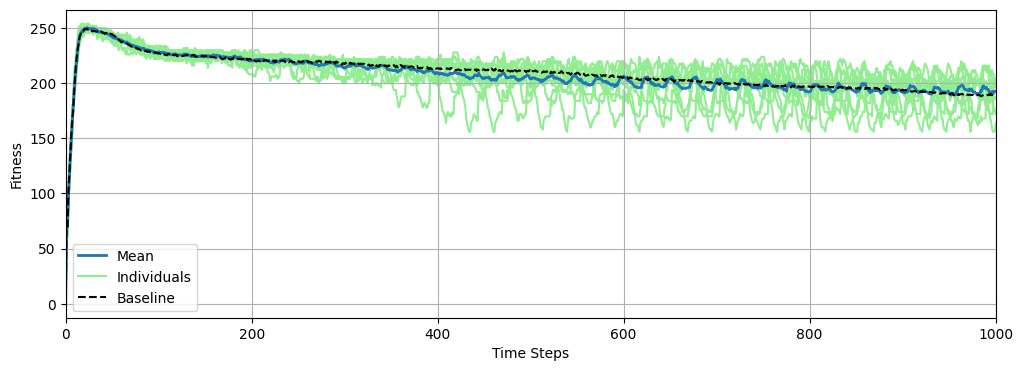

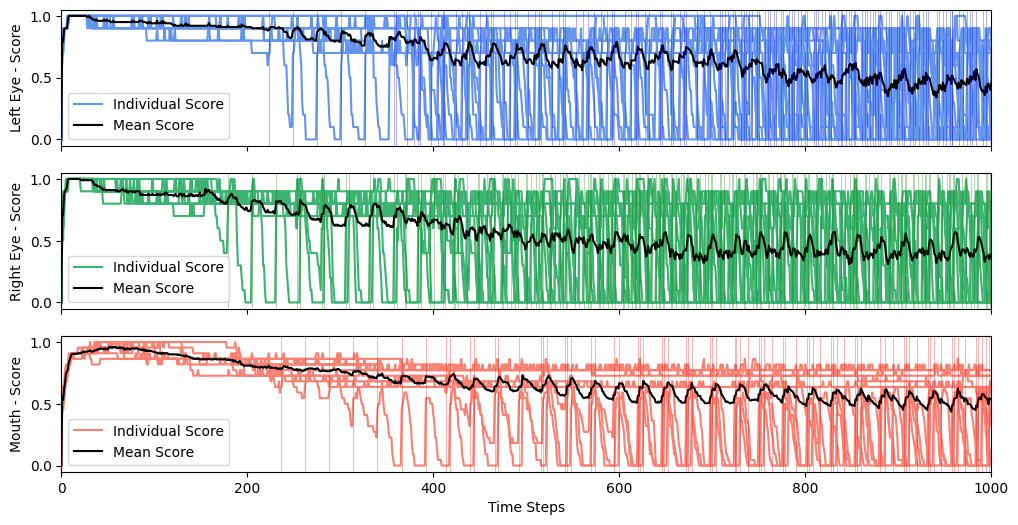

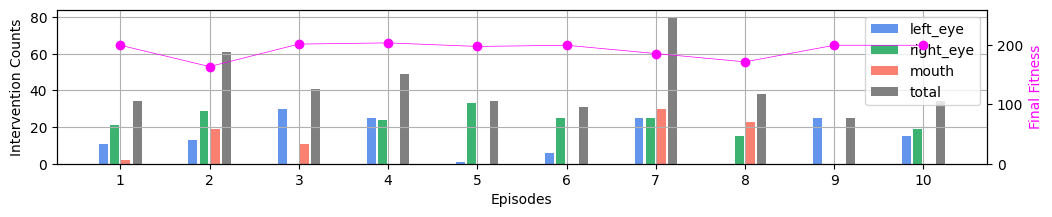

In [17]:
recovery.plot_fitness(recovery_data_01, aging_path=aging_path, data_default=data_trained, **recovery_data_01_kwargs, dpi=300)

/tmp/ipykernel_57409/1022323897.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  highlight_ax.set_xticklabels(["Left Eye", "Right Eye", "Mouth"], rotation=45)


export figure data/aging/recovery/socket_loss/smiley_16x16/recover_socket-threshold_0.6-development_150-horizon_25-rnnstate_reset-inject_init-correct_all-paper-fig.pdf


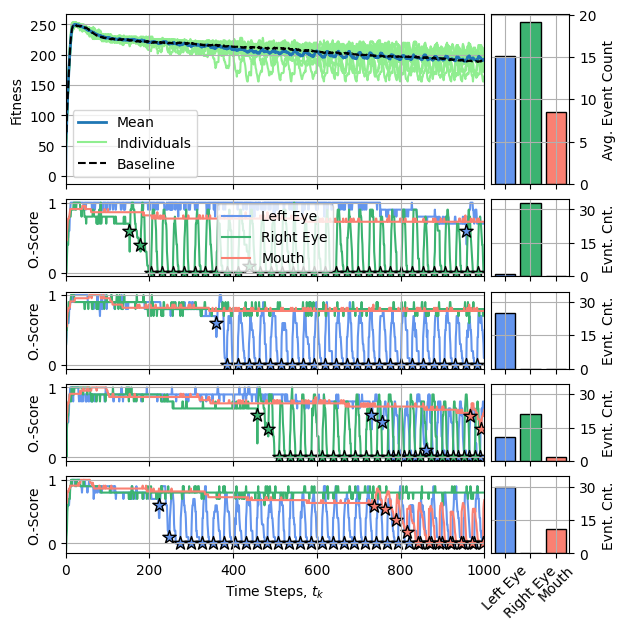

In [18]:
plot_recovery(recovery_data_01, num_trajectories=10, trajs=[4, 8, 0, 2], **recovery_data_01_kwargs)

### Inject entire __target__ organ after sufficient damage

In [19]:
recovery_data_01a_kwargs = dict(
    threshold    = 0.6,    # threshold for intervention (if organ relative fitness is below this value)
    development  = 150,     # developmental stage, no intervention until this time
    horizon      = 25,     # time steps between interventions (TODO: resolve multiple calls of schedule)
    reset_memory = True,    # boolean to control whether to erase RNN state of intervened cells
    inject_initial = None,  # whether to inject the initial or the mature state)
    only_correct_wrongs = False,
    **organs
)


filename = os.path.join(aging_path, recovery.get_filename(recover="socket", **recovery_data_01a_kwargs))
try:
    recovery_data_01a = load_data(filename=filename)
    
except:
    recovery_data_01a = recovery.run_recovery(world_path=world_path, **recovery_data_01a_kwargs)
    save_data(recovery_data_01a, filename=filename)


loading from 'data/aging/recovery/socket_loss/smiley_16x16/recover_socket-threshold_0.6-development_150-horizon_25-rnnstate_reset-inject_target-correct_all.h5'
node: 'action', shape: (10, 1001, 16, 16, 4)
node: 'cumulative_reward', shape: (10, 1001)
node: 'embedding', shape: (10, 1001, 16, 16, 8)
node: 'left_eye_interventions', shape: (10, 1001)
node: 'mouth_interventions', shape: (10, 1001)
node: 'reward', shape: (10, 1001)
node: 'right_eye_interventions', shape: (10, 1001)
node: 'state', shape: (10, 1001, 16, 16, 4)
node: 'type', shape: (10, 1001, 16, 16)


export figure data/aging/recovery/socket_loss/smiley_16x16/recover_socket-threshold_0.6-development_150-horizon_25-rnnstate_reset-inject_target-correct_all-reward.png
export figure data/aging/recovery/socket_loss/smiley_16x16/recover_socket-threshold_0.6-development_150-horizon_25-rnnstate_reset-inject_target-correct_all-organ-fitness.png
export figure data/aging/recovery/socket_loss/smiley_16x16/recover_socket-threshold_0.6-development_150-horizon_25-rnnstate_reset-inject_target-correct_all-intervention-count.png


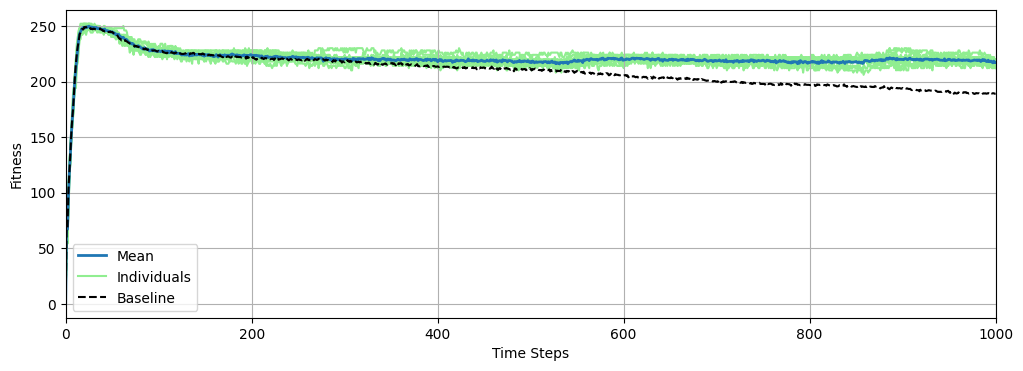

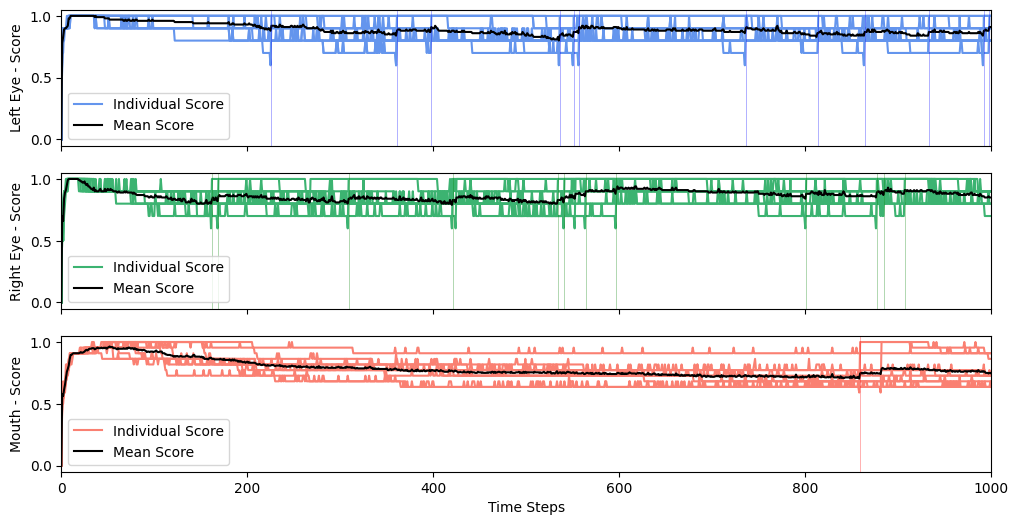

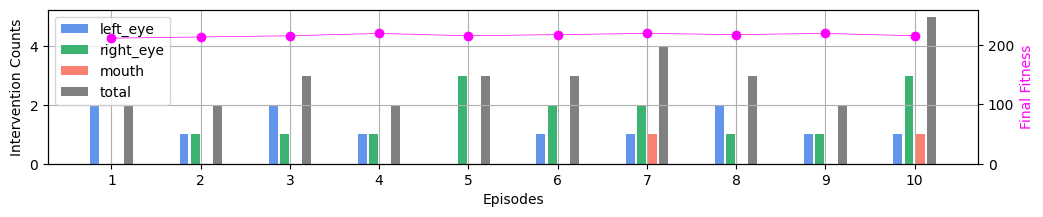

In [20]:
recovery.plot_fitness(recovery_data_01a, aging_path=aging_path, data_default=data_trained, **recovery_data_01a_kwargs, dpi=300)

/tmp/ipykernel_57409/1022323897.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  highlight_ax.set_xticklabels(["Left Eye", "Right Eye", "Mouth"], rotation=45)


export figure data/aging/recovery/socket_loss/smiley_16x16/recover_socket-threshold_0.6-development_150-horizon_25-rnnstate_reset-inject_target-correct_all-paper-fig.pdf


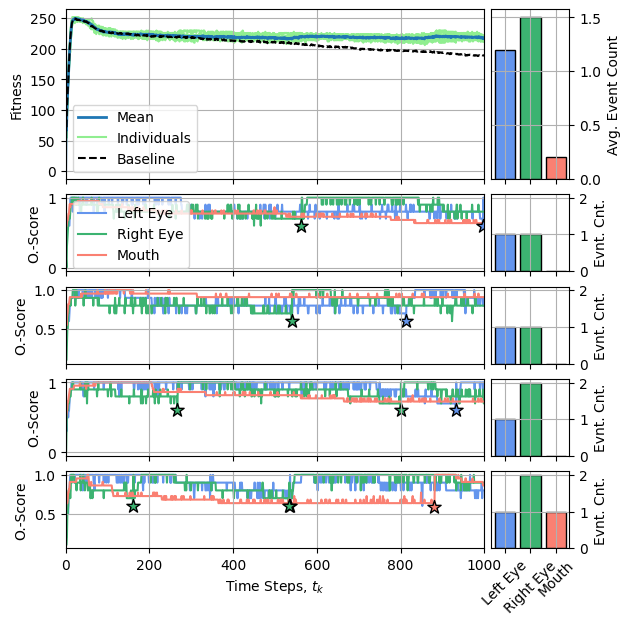

In [21]:
plot_recovery(recovery_data_01a, num_trajectories=10, trajs=[1, 3, 5, 6], **recovery_data_01a_kwargs)

### Inject __embryonic cells only__ after sufficient organ damage

In [22]:
recovery_data_02_kwargs = dict(
    threshold    = 0.6,    # threshold for intervention (if organ relative fitness is below this value)
    development  = 150,     # developmental stage, no intervention until this time
    horizon      = 25,     # time steps between interventions (TODO: resolve multiple calls of schedule)
    reset_memory = True,    # boolean to control whether to erase RNN state of intervened cells
    inject_initial = initial_state,  # whether to inject the initial or the mature state)
    only_correct_wrongs = True,
    **organs,
)

filename = os.path.join(aging_path, recovery.get_filename(recover="socket", **recovery_data_02_kwargs))
try:
    recovery_data_02 = load_data(filename=filename)
    
except:
    recovery_data_02 = recovery.run_recovery(world_path=world_path, **recovery_data_02_kwargs)
    save_data(recovery_data_02, filename=filename)


loading from 'data/aging/recovery/socket_loss/smiley_16x16/recover_socket-threshold_0.6-development_150-horizon_25-rnnstate_reset-inject_init-correct_wrongs.h5'
node: 'action', shape: (10, 1001, 16, 16, 4)
node: 'cumulative_reward', shape: (10, 1001)
node: 'embedding', shape: (10, 1001, 16, 16, 8)
node: 'left_eye_interventions', shape: (10, 1001)
node: 'mouth_interventions', shape: (10, 1001)
node: 'reward', shape: (10, 1001)
node: 'right_eye_interventions', shape: (10, 1001)
node: 'state', shape: (10, 1001, 16, 16, 4)
node: 'type', shape: (10, 1001, 16, 16)


export figure data/aging/recovery/socket_loss/smiley_16x16/recover_socket-threshold_0.6-development_150-horizon_25-rnnstate_reset-inject_init-correct_wrongs-reward.png
export figure data/aging/recovery/socket_loss/smiley_16x16/recover_socket-threshold_0.6-development_150-horizon_25-rnnstate_reset-inject_init-correct_wrongs-organ-fitness.png
export figure data/aging/recovery/socket_loss/smiley_16x16/recover_socket-threshold_0.6-development_150-horizon_25-rnnstate_reset-inject_init-correct_wrongs-intervention-count.png


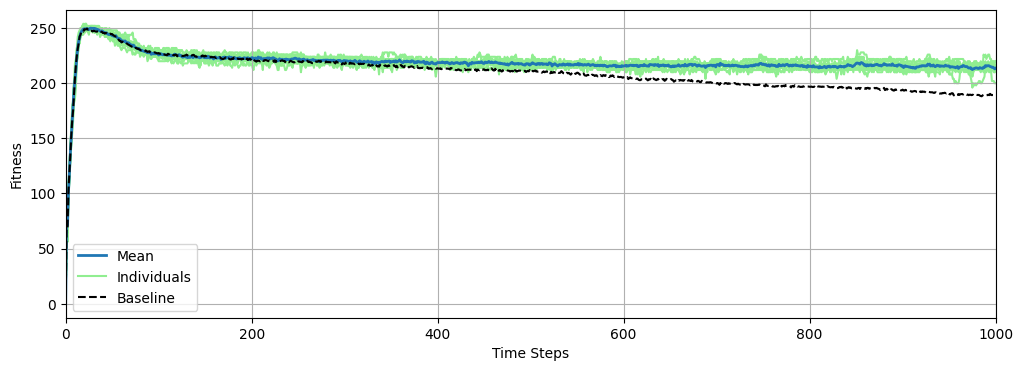

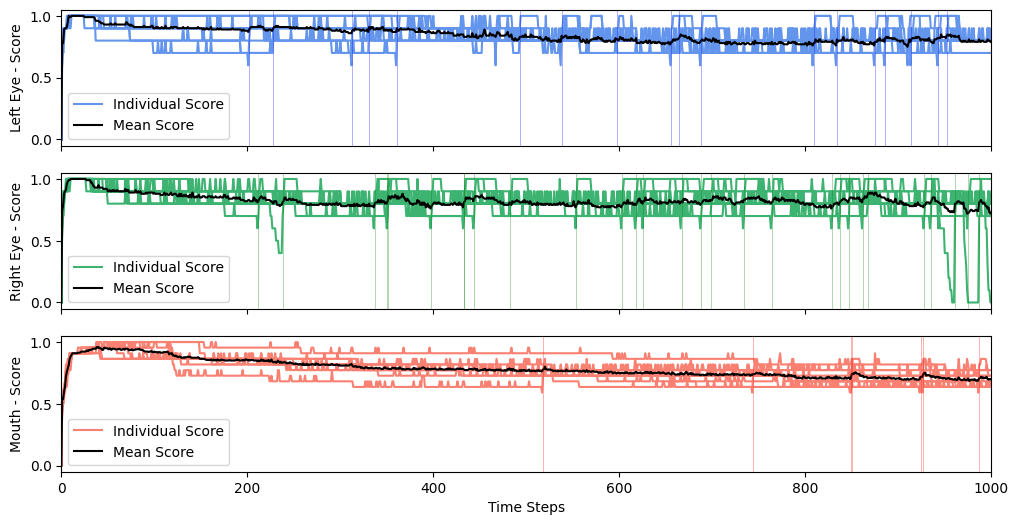

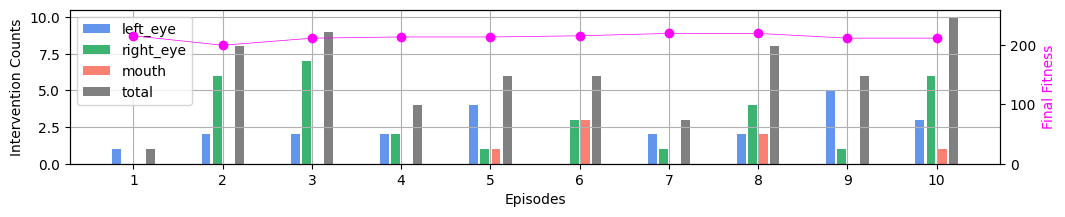

In [23]:
recovery.plot_fitness(recovery_data_02, aging_path=aging_path, data_default=data_trained, **recovery_data_02_kwargs, dpi=300)

/tmp/ipykernel_57409/1022323897.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  highlight_ax.set_xticklabels(["Left Eye", "Right Eye", "Mouth"], rotation=45)


export figure data/aging/recovery/socket_loss/smiley_16x16/recover_socket-threshold_0.6-development_150-horizon_25-rnnstate_reset-inject_init-correct_wrongs-paper-fig.pdf


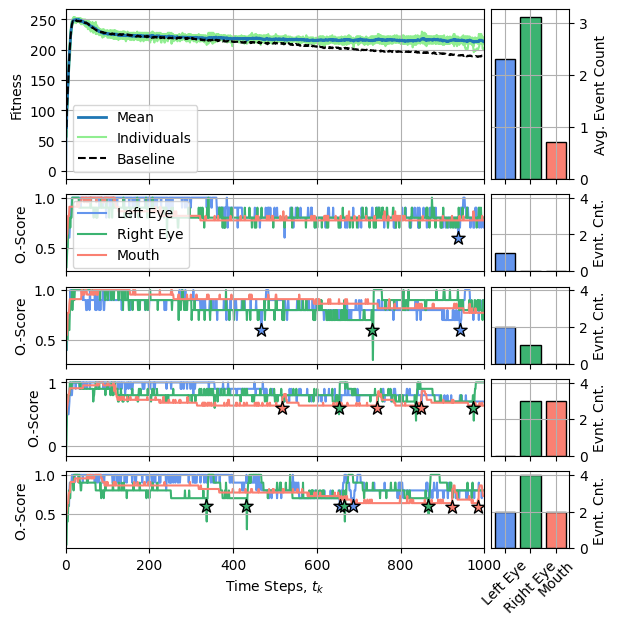

In [24]:
plot_recovery(recovery_data_02, num_trajectories=10, trajs=[0, 6, 5, 7], **recovery_data_02_kwargs)

### Inject __target cells only__ after sufficient organ damage

In [25]:
recovery_data_03_kwargs = dict(
    threshold    = 0.6,    # threshold for intervention (if organ relative fitness is below this value)
    development  = 150,     # developmental stage, no intervention until this time
    horizon      = 25,     # time steps between interventions (TODO: resolve multiple calls of schedule)
    reset_memory = True,    # boolean to control whether to erase RNN state of intervened cells
    inject_initial = None,  # whether to inject the initial or the mature state)
    only_correct_wrongs = True,
    **organs
)

filename = os.path.join(aging_path, recovery.get_filename(recover="socket", **recovery_data_03_kwargs))
try:
    recovery_data_03 = load_data(filename=filename)

except:
    recovery_data_03 = recovery.run_recovery(world_path=world_path, **recovery_data_03_kwargs)
    save_data(recovery_data_03, filename=filename)

loading from 'data/aging/recovery/socket_loss/smiley_16x16/recover_socket-threshold_0.6-development_150-horizon_25-rnnstate_reset-inject_target-correct_wrongs.h5'
node: 'action', shape: (10, 1001, 16, 16, 4)
node: 'cumulative_reward', shape: (10, 1001)
node: 'embedding', shape: (10, 1001, 16, 16, 8)
node: 'left_eye_interventions', shape: (10, 1001)
node: 'mouth_interventions', shape: (10, 1001)
node: 'reward', shape: (10, 1001)
node: 'right_eye_interventions', shape: (10, 1001)
node: 'state', shape: (10, 1001, 16, 16, 4)
node: 'type', shape: (10, 1001, 16, 16)


export figure data/aging/recovery/socket_loss/smiley_16x16/recover_socket-threshold_0.6-development_150-horizon_25-rnnstate_reset-inject_target-correct_wrongs-reward.png
export figure data/aging/recovery/socket_loss/smiley_16x16/recover_socket-threshold_0.6-development_150-horizon_25-rnnstate_reset-inject_target-correct_wrongs-organ-fitness.png
export figure data/aging/recovery/socket_loss/smiley_16x16/recover_socket-threshold_0.6-development_150-horizon_25-rnnstate_reset-inject_target-correct_wrongs-intervention-count.png


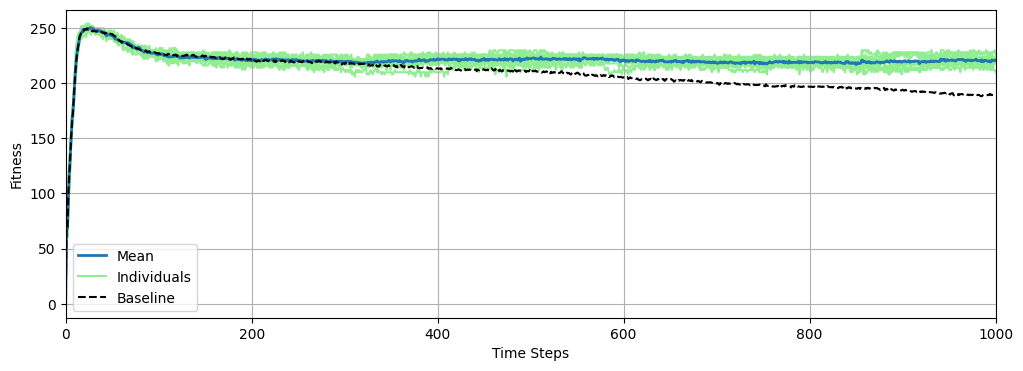

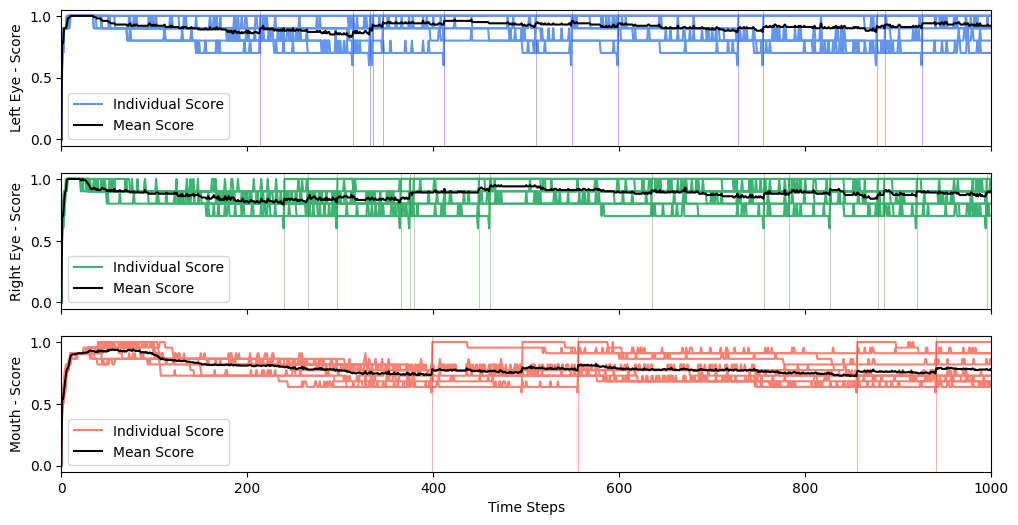

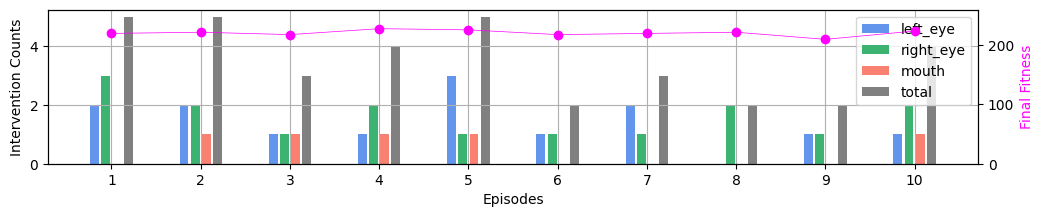

In [26]:
recovery.plot_fitness(recovery_data_03, aging_path=aging_path, data_default=data_trained, **recovery_data_03_kwargs, dpi=300)

/tmp/ipykernel_57409/1022323897.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  highlight_ax.set_xticklabels(["Left Eye", "Right Eye", "Mouth"], rotation=45)


export figure data/aging/recovery/socket_loss/smiley_16x16/recover_socket-threshold_0.6-development_150-horizon_25-rnnstate_reset-inject_target-correct_wrongs-paper-fig.pdf


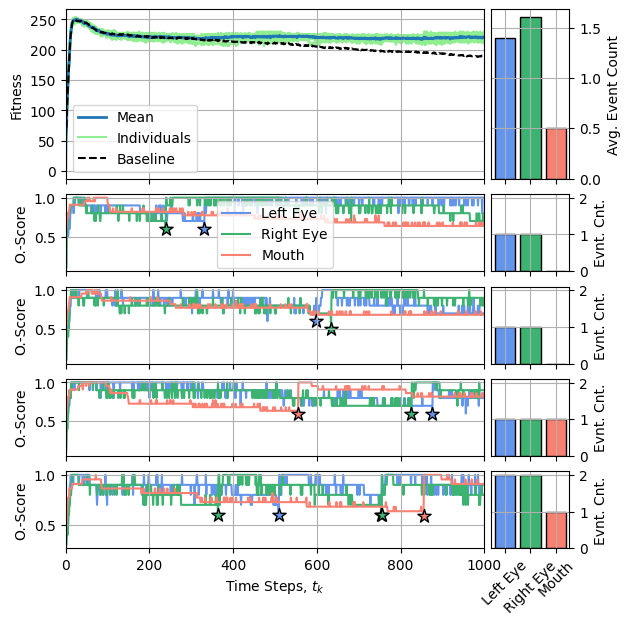

In [27]:
plot_recovery(recovery_data_03, num_trajectories=10, trajs=[5, 8, 2, 1], **recovery_data_03_kwargs)

## Movies

### Reference data (no interventions)

In [ ]:
recovery.get_movie(data_trained, export_path=os.path.join(aging_path, "default-behavior.mp4"))

### Whole embryonic organ replacement

In [ ]:
recovery.get_movie(recovery_data_01, recovery.get_movie_name(recover="socket", aging_path=aging_path, **recovery_data_01_kwargs))

### Whole target organ replacement

In [ ]:
recovery.get_movie(recovery_data_01a, recovery.get_movie_name(recover="socket", aging_path=aging_path, **recovery_data_01a_kwargs))

### Affected cell embryonic cell replacement

In [ ]:
recovery.get_movie(recovery_data_02, recovery.get_movie_name(recover="socket", aging_path=aging_path, **recovery_data_02_kwargs))

### Affected cell target cell replacement

In [ ]:
recovery.get_movie(recovery_data_03, recovery.get_movie_name(recover="socket", aging_path=aging_path, **recovery_data_03_kwargs))